#Load The Data Set

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
# Unzip the file
!unzip '/content/drive/MyDrive/DL/CNN_Articels_clean.zip' -d '/content/'

# Load the dataset
df = pd.read_csv('/content/CNN_Articels_clean.csv')

# Check the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Get a summary of the data types and non-null counts
print("\nData Summary:")
print(df.info())

# Check the distribution of categories
print("\nDistribution of categories:")
print(df['Category'].value_counts())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/DL/CNN_Articels_clean.zip
  inflating: /content/CNN_Articels_clean.csv  
First few rows of the dataset:
   Index                                             Author  \
0      0                                 Jacopo Prisco, CNN   
1      1                              Stephanie Bailey, CNN   
2      2  Words by Stephanie Bailey, video by Zahra Jamshed   
3      3                                     Kathryn Vasel    
4      4                    Paul R. La Monica, CNN Business   

        Date published  Category    Section  \
0  2021-07-15 02:46:59      news      world   
1  2021-05-12 07:52:09      news      world   
2  2021-06-16 02:51:30      news       asia   
3  2022-03-18 14:37:21  business    success   
4  2022-03-19 11:41:08  business  investing   

                                                 Url  \
0  https://www.c

#Clean Data Set

In [ ]:
# Drop rows with missing 'Article text'
df_cleaned = df.dropna(subset=['Article text'])

# Verify there are no more missing values in the 'Article text' column
print("\nMissing values after cleaning:")
print(df_cleaned.isnull().sum())


Missing values after cleaning:
Index              0
Author             0
Date published     0
Category           0
Section            0
Url                0
Headline           0
Description        0
Keywords           0
Second headline    0
Article text       0
dtype: int64


In [ ]:
import re

# Function to remove the phrase '(CNN)' from the article text
def remove_cnn_phrase(text):
    # Remove variations of (CNN), (cnn), or extra spaces
    return re.sub(r'\(cnn\)|\(CNN\)', '', text).strip()

# Apply the function to the 'Article text' column
df_cleaned['Article text'] = df_cleaned['Article text'].apply(remove_cnn_phrase)

# Check weather '(CNN)' was successfully removed
print(df_cleaned['Article text'].head())


0    Right now, there's a shortage of truck drivers...
1    Working in a factory or warehouse can mean doi...
2    In a Hong Kong warehouse, a swarm of autonomou...
3    The pandemic thrust the working world into a n...
4    New York (CNN Business)March Madness isn't jus...
Name: Article text, dtype: object


<ipython-input-9-d6b8de0340dc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Article text'] = df_cleaned['Article text'].apply(remove_cnn_phrase)


In [ ]:
# Convert 'Date published' to datetime format
df_cleaned['Date published'] = pd.to_datetime(df_cleaned['Date published'], errors='coerce')

# Check for any invalid dates that couldn't be converted
print("\nInvalid dates after conversion:")
print(df_cleaned[df_cleaned['Date published'].isnull()])

# Drop rows with invalid dates, if necessary
df_cleaned = df_cleaned.dropna(subset=['Date published'])

# Check final shape of the cleaned dataset
print("\nFinal dataset shape after cleaning:")
print(df_cleaned.shape)


Invalid dates after conversion:
Empty DataFrame
Columns: [Index, Author, Date published, Category, Section, Url, Headline, Description, Keywords, Second headline, Article text]
Index: []

Final dataset shape after cleaning:
(37940, 11)


<ipython-input-10-c97cd517248b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date published'] = pd.to_datetime(df_cleaned['Date published'], errors='coerce')


In [ ]:
# Save the cleaned dataset to a new CSV file
df_cleaned.to_csv('data/cnn_articles_cleaned.csv', index=False)

#Data Preprocessing

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords from NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Define stop words
stop_words = set(stopwords.words('english'))

# Function for text preprocessing
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stop words
    words = [word for word in words if word not in stop_words]

    # Join the words back into a single string
    return ' '.join(words)

# Apply preprocessing to the 'Article text' column
df_cleaned['cleaned_text'] = df_cleaned['Article text'].apply(preprocess_text)

# Check the first few rows of the cleaned text
print(df_cleaned[['Article text', 'cleaned_text']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                        Article text  \
0  Right now, there's a shortage of truck drivers...   
1  Working in a factory or warehouse can mean doi...   
2  In a Hong Kong warehouse, a swarm of autonomou...   
3  The pandemic thrust the working world into a n...   
4  New York (CNN Business)March Madness isn't jus...   

                                        cleaned_text  
0  right theres shortage truck drivers us worldwi...  
1  working factory warehouse mean task repetition...  
2  hong kong warehouse swarm autonomous robots wo...  
3  pandemic thrust working world new reality marc...  
4  new york cnn businessmarch madness isnt colleg...  


#Tokenization and Padding

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the maximum number of words to use (top 20,000 most frequent words)
max_words = 20000
# Define the maximum length of a sequence (for padding)
max_len = 100

# Initialize the tokenizer and fit on the cleaned text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_cleaned['cleaned_text'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df_cleaned['cleaned_text'])

# Apply padding to ensure all sequences have the same length
X = pad_sequences(sequences, maxlen=max_len)

# Convert categories to integer labels (for classification)
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_cleaned['Category'])

# Train, test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes of the final processed data
print("Shape of X (features):", X.shape)
print("Shape of y (labels):", y.shape)

Shape of X (features): (37940, 100)
Shape of y (labels): (37940,)


#Build LSTM Model

In [ ]:
#Number of unique news categories.

unique_category_count = df['Category'].nunique()
print(f"Number of unique categories: {unique_category_count}")

Number of unique categories: 9


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, BatchNormalization, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the LSTM model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len, input_shape=(max_len,)))

# LSTM layer with L2 regularization and Dropout
model.add(LSTM(128, activation='relu', kernel_regularizer=l2(0.01), return_sequences=True))
model.add(Dropout(0.5))

# Batch normalization
model.add(BatchNormalization())

# LSTM layer with L2 regularization
model.add(LSTM(64, activation='tanh', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# Batch normalization
model.add(BatchNormalization())

# Output layer with L2 regularization
model.add(Dense(unique_category_count, activation='softmax', kernel_regularizer=l2(0.01)))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0005)

#model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


475/475 ━━━━━━━━━━━━━━━━━━━━ 121s 245ms/step - accuracy: 0.6787 - loss: 2.6514 - val_accuracy: 0.9418 - val_loss: 0.5823 - learning_rate: 0.0010
Epoch 2/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 124s 209ms/step - accuracy: 0.8938 - loss: 0.5557 - val_accuracy: 0.9002 - val_loss: 0.4538 - learning_rate: 0.0010
Epoch 3/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 130s 185ms/step - accuracy: 0.9192 - loss: 0.3720 - val_accuracy: 0.9096 - val_loss: 0.4150 - learning_rate: 0.0010
Epoch 4/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 142s 184ms/step - accuracy: 0.9315 - loss: 0.2883 - val_accuracy: 0.9020 - val_loss: 0.3843 - learning_rate: 0.0010
Epoch 5/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 145s 191ms/step - accuracy: 0.9278 - loss: 0.3093 - val_accuracy: 0.9324 - val_loss: 0.3019 - learning_rate: 0.0010
Epoch 6/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 145s 197ms/step - accuracy: 0.9505 - loss: 0.2231 - val_accuracy: 0.9385 - val_loss: 0.2579 - learning_rate: 0.0010
Epoch 7/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 137s 187ms/step - accuracy: 0.9579 

#Graphical Representation of Accuracy and Loss

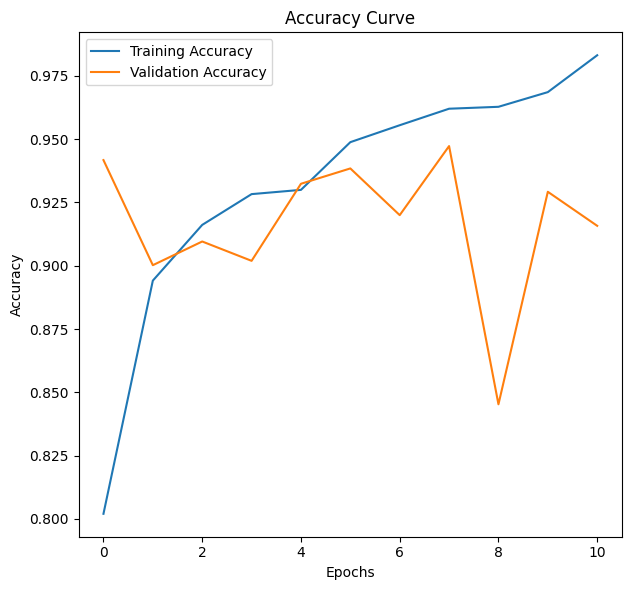

In [ ]:
import matplotlib.pyplot as plt

# Plotting Curve
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


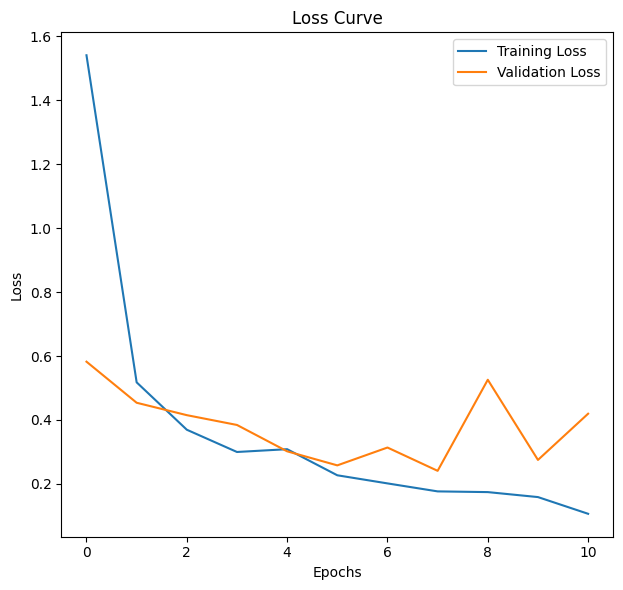

In [ ]:
# Loss

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#Test Accuracy and Loss

In [13]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"\nTest Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8901 - loss: 0.4462

Test Loss: 0.46862930059432983
Test Accuracy: 0.8871902823448181


#Confusion Matrix

238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step


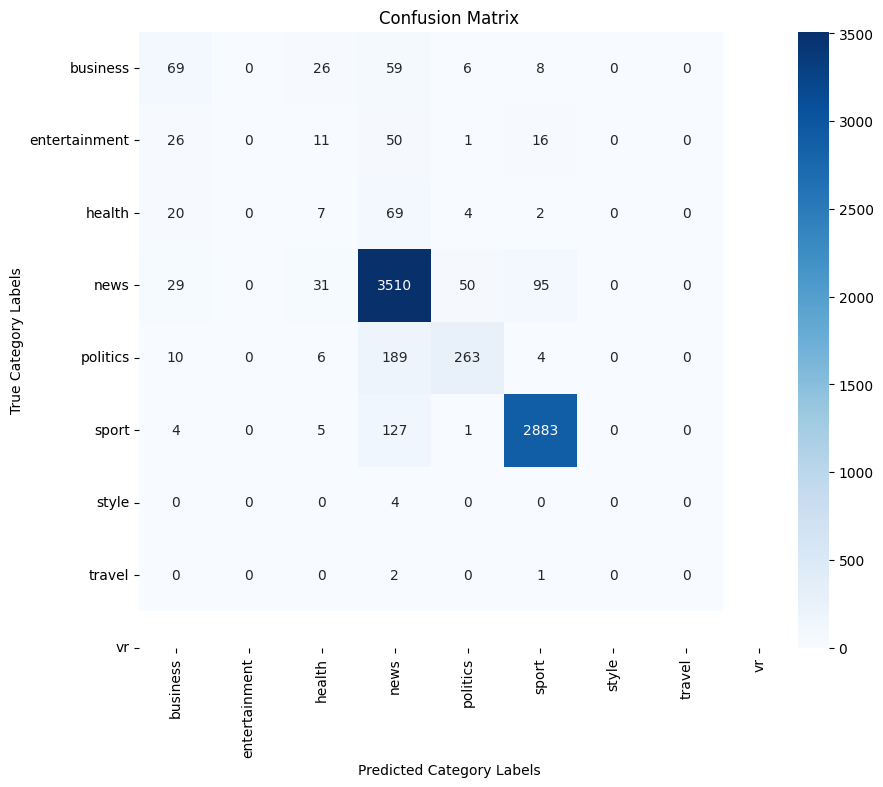

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels for the test set
y_pred = model.predict(X_test)

# Get the index of the highest probability class
y_pred_classes = y_pred.argmax(axis=1)

# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Category Labels')
plt.ylabel('True Category Labels')
plt.show()